##Цель.

Выполнить Стэкинг, Бэгин и Бустинг.

По позможности добиться максимального результата точности. 

Что было сделано:
Реализованы 3 метода. Дополнительно реализован метод на основе нескольких слоев моделей (1 предсказывает 1-3, второй 3-4/5-6-7/8-9)

---
Подготовка данных

In [0]:
!pip install vecstack 

In [0]:
!pip install catboost

In [0]:
!pip install xgboost

In [213]:
!pip install hyperopt

In [214]:
!pip install yellowbrick

In [0]:
#загрузка библтотек
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import BaggingClassifier

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from imblearn.over_sampling import ADASYN,SMOTE


In [0]:
from yellowbrick.classifier import ConfusionMatrix
import pickle

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [219]:
#Загрузка файла. Если загрузка не требуеться: пропустить. 
from google.colab import files

uploaded = files.upload()
filename=''
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  filename=fn

Saving winequality-white.csv to winequality-white (1).csv
User uploaded file "winequality-white.csv" with length 264426 bytes


In [0]:
#загружаем датафрейм
data = pd.read_csv(filename, encoding='cp1251', sep=';')

In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [0]:
# увеличим число путем копирования
for i in range(0,2):
  for j in range(0,2):
   test=pd.DataFrame()
   test=data[data['quality']==9]
   data=shuffle(data)
   data = pd.concat([data, test])
  test=data[data['quality']==3]
  data = pd.concat([data, test])
  data=shuffle(data)

In [222]:
data['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [0]:
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [224]:
data.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

---
Код ниже стоит пропустить. Он нужен для валидации данных в google AutoML. Пропускаем!


In [0]:
#Полготовка данных для выгрузки в AutoML - смысл в том, размечаем выборку сами.
test={0:'TRAIN',7:'VALIDATE',9:'TEST'}
data['AutoML']= np.random.choice(list(test), len(data))

In [0]:
data['AutoML'] = data['AutoML'].map(test)

In [112]:
data['AutoML'].value_counts()

TEST        1695
VALIDATE    1671
TRAIN       1667
Name: AutoML, dtype: int64

In [0]:
data.to_csv('outn.csv',encoding='utf-8',index=False)
data=data.drop('AutoML',axis=1)

---

In [0]:
data['quality_new']=data['quality'].map({3:0,4:0,5:1,6:1,7:1,8:2,9:2})

In [0]:
y = data ['quality_new'] 
X=data.drop('quality',axis=1)

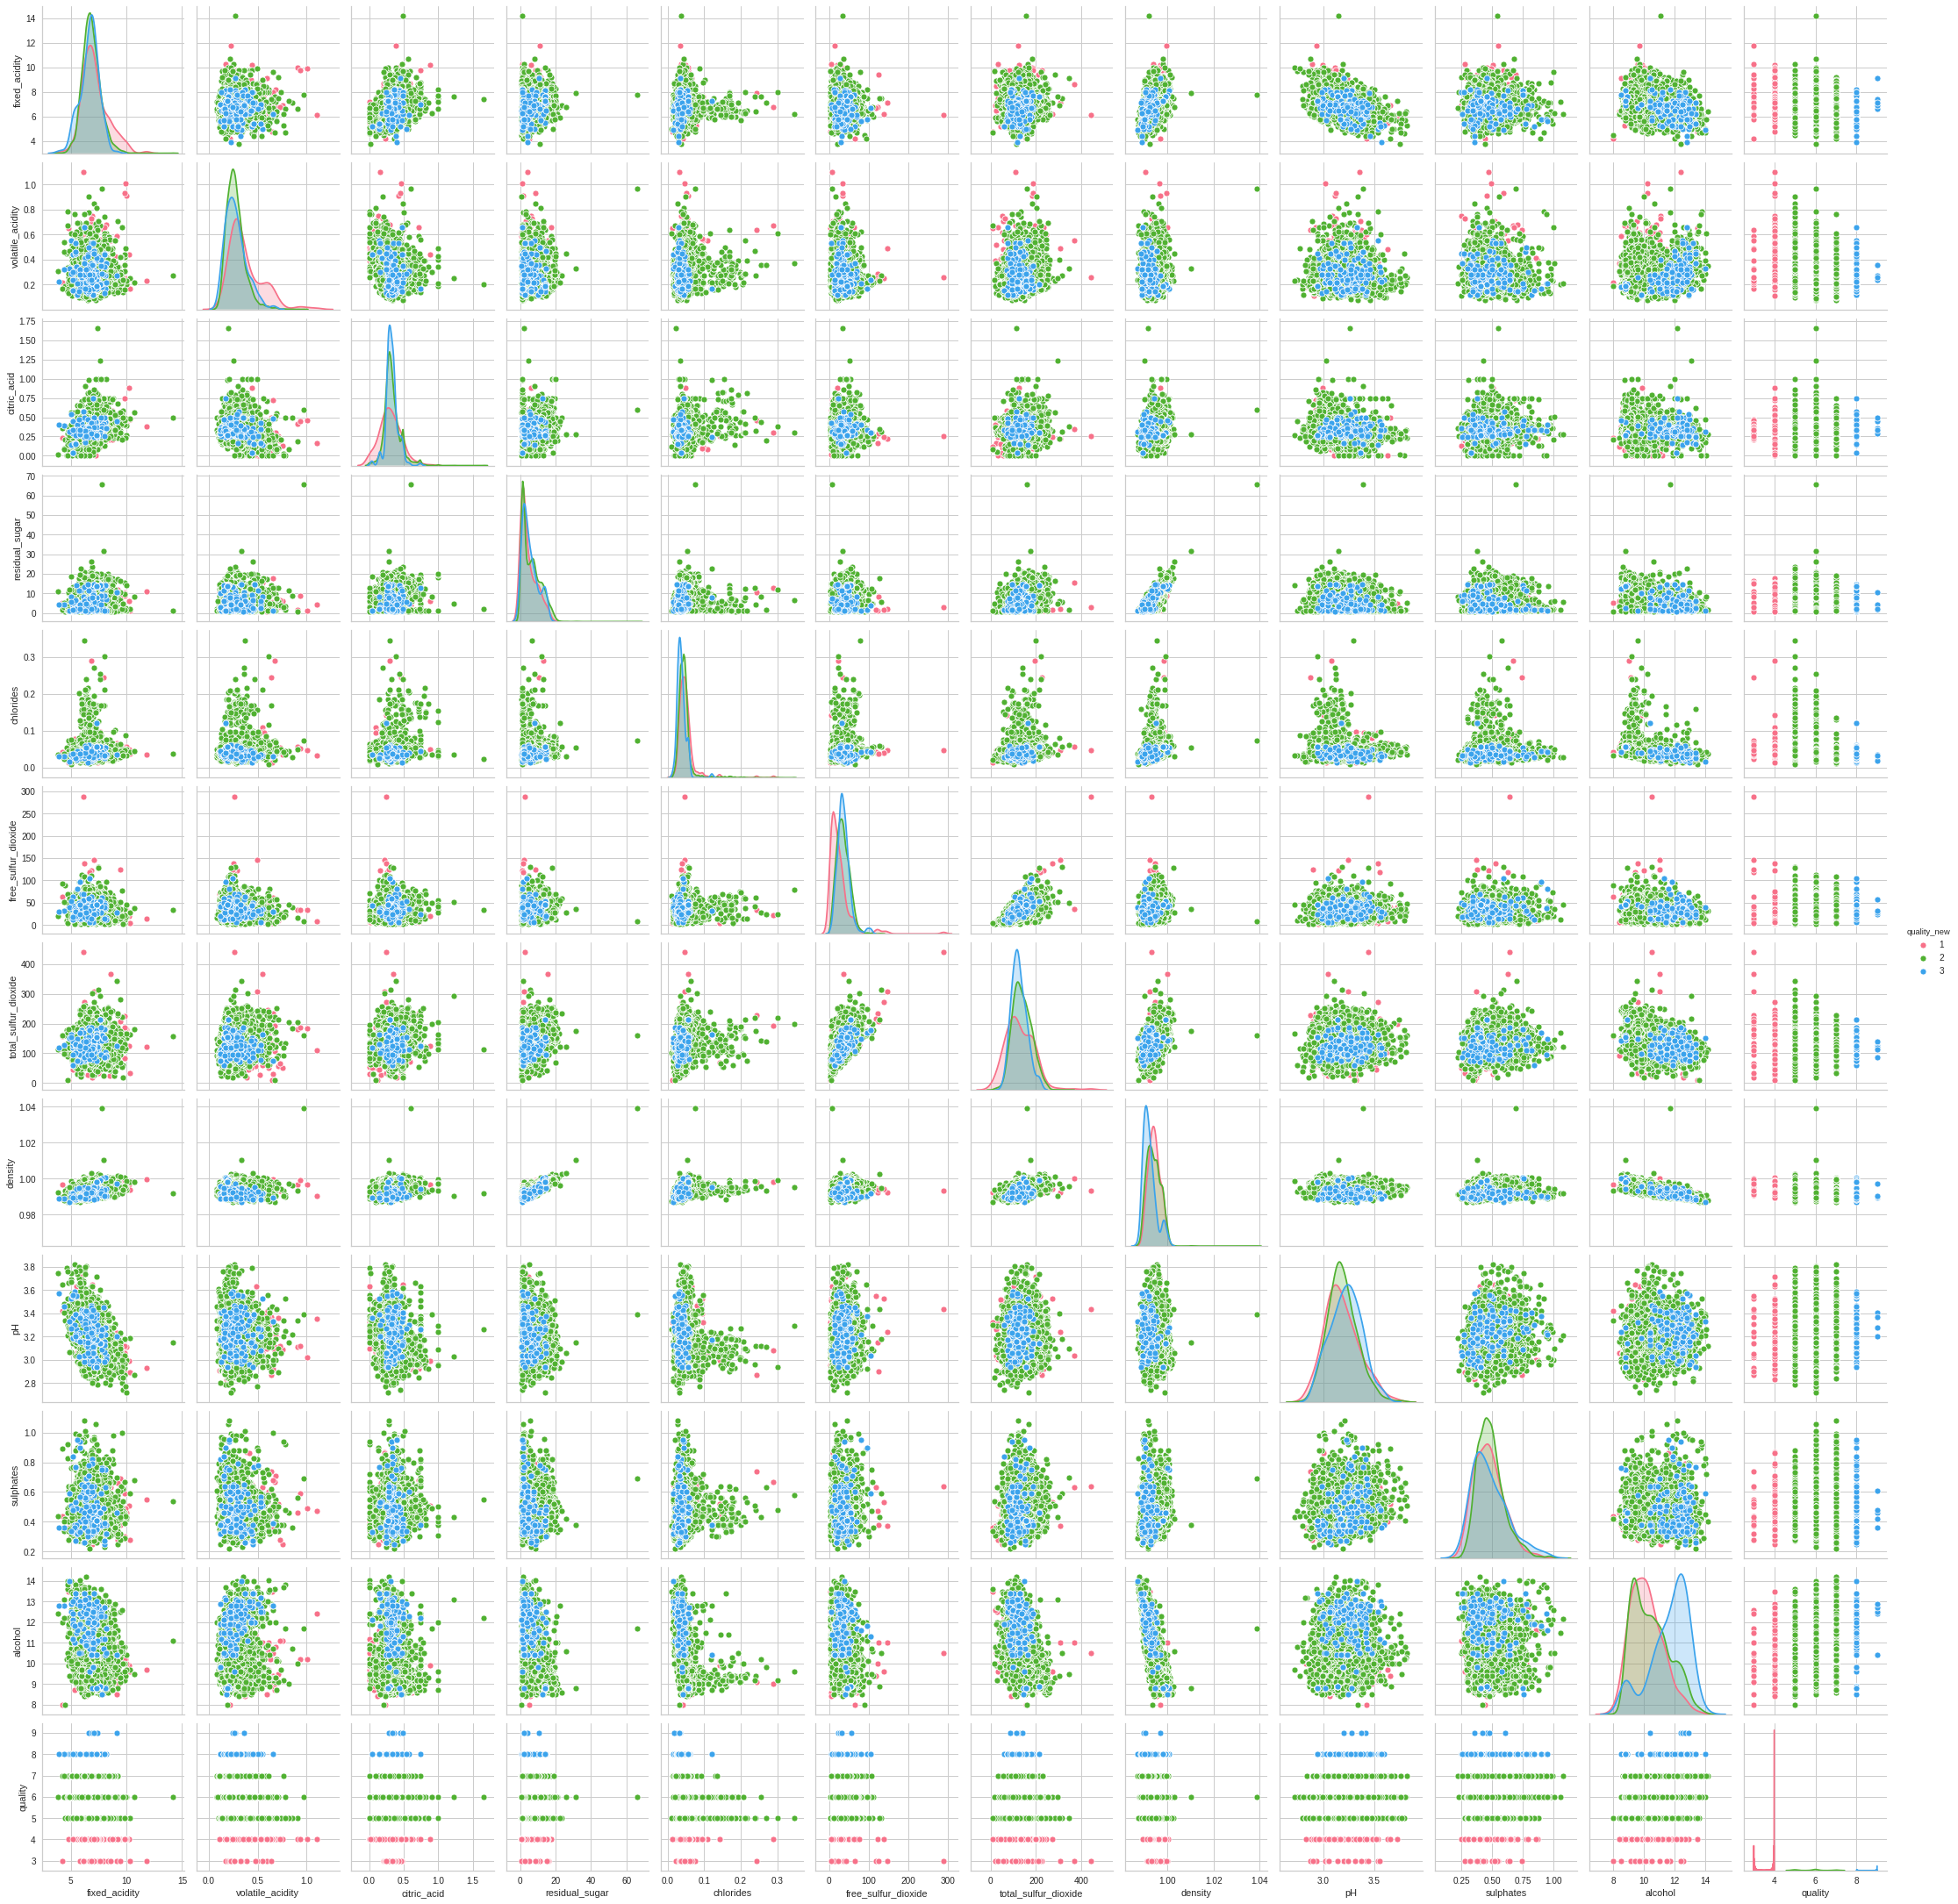

In [236]:
#Небольшая визуализация для общего понимания. 
features = data.copy(deep=True)
features['quality_new'] = y.astype('str').map({'0': '1', '1': '2', '2': '3'})
sns_plot=sns.pairplot(features,  diag_kind='kde', palette='husl', hue='quality_new')
sns_plot.savefig("output.png")

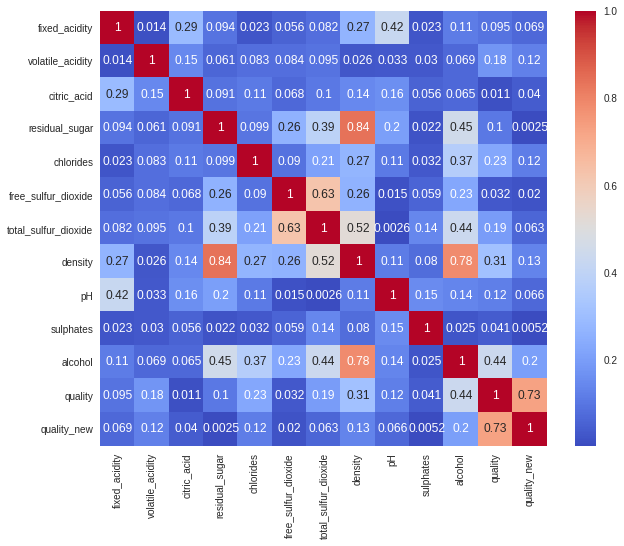

In [0]:
corr_matrix = data.corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

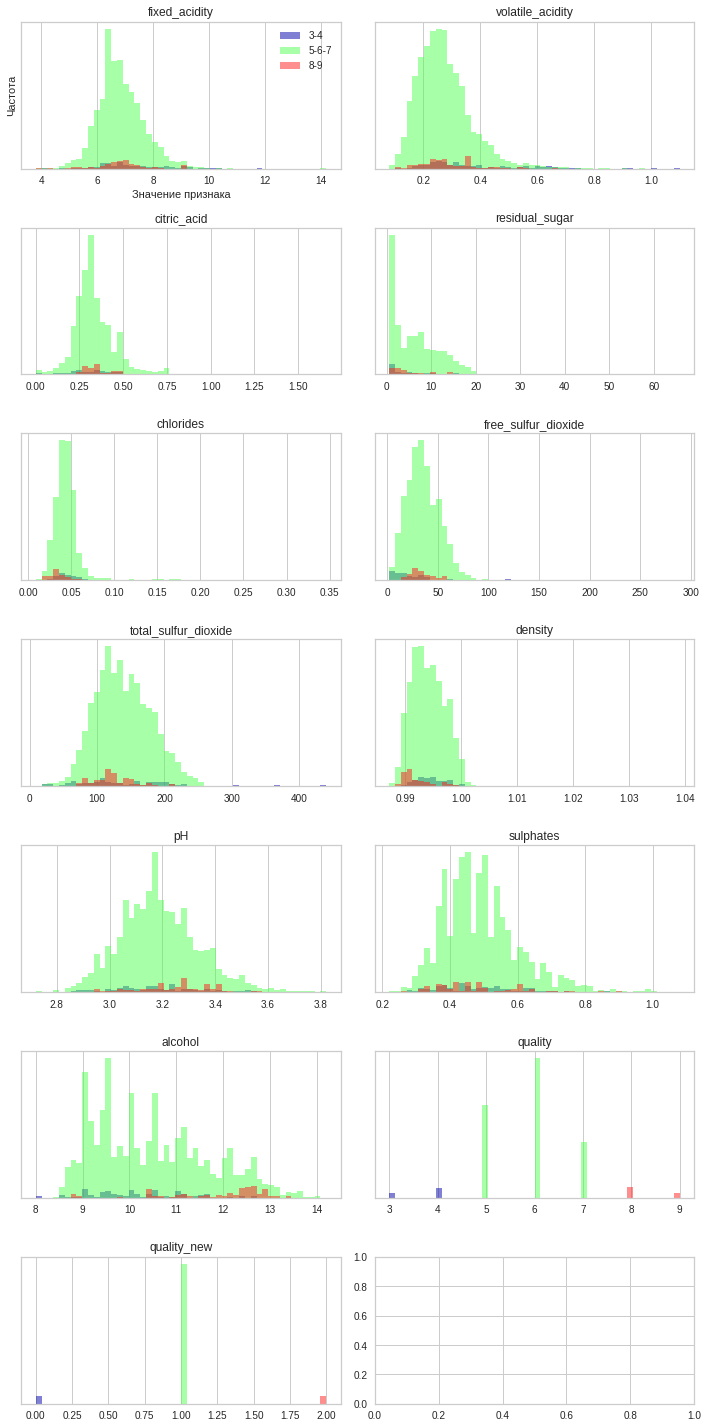

In [0]:
import numpy as np
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
malignant = data[data['quality_new']== 0]
benign = data[data['quality_new'] == 1]
testbenign = data[data['quality_new'] == 2]
ax = axes.ravel()
for i in range(len(data.columns)):
    _, bins = np.histogram(data.iloc[:, i], bins=50)
    ax[i].hist(malignant.iloc[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign.iloc[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].hist(testbenign.iloc[:, i], bins=bins, color=mglearn.cm3(1), alpha=.5)
    ax[i].set_title(data.columns[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Значение признака")
ax[0].set_ylabel("Частота")
ax[0].legend(['3-4', '5-6-7','8-9'], loc="best")
fig.tight_layout()

---
Анализируем

В целом можно обратить внимание только на алкоголь так как он выделяеться и можно придумать на основании него новый признак. Остальное несет слабую информативность..

(-1, 4)

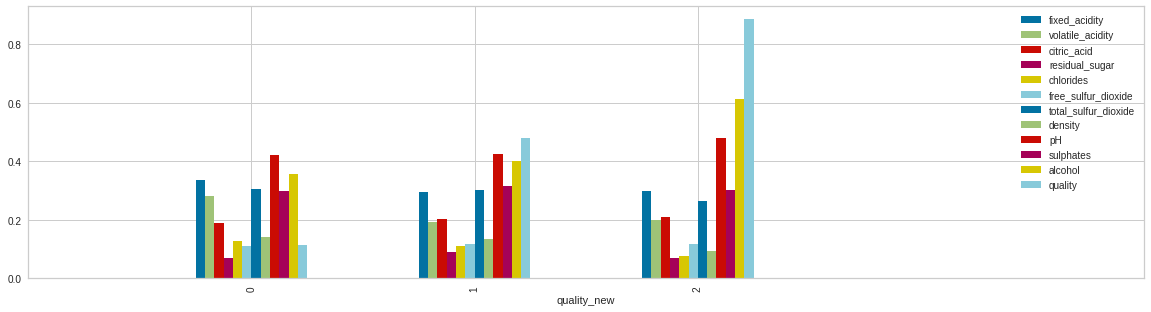

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
cols_to_scale = data.columns.tolist()
cols_to_scale.remove('quality_new')
scaled_wine_df = data.copy()
scaler = MinMaxScaler()
scaled_wine_df[cols_to_scale] = scaler.fit_transform(scaled_wine_df[cols_to_scale])
scaled_wine_df.groupby('quality_new').mean().plot(kind='bar', figsize=(20,5))
plt.xlim(-1,4)

(-1, 9)

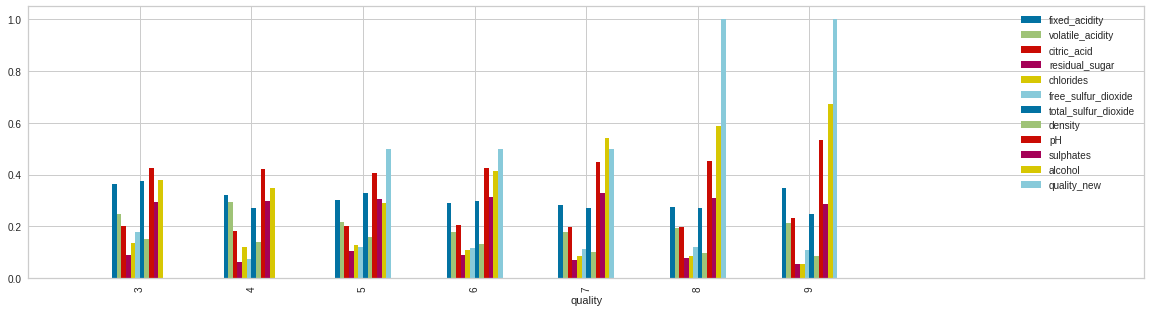

In [0]:
cols_to_scale = data.columns.tolist()
cols_to_scale.remove('quality')
scaled_wine_df = data.copy()
scaler = MinMaxScaler()
scaled_wine_df[cols_to_scale] = scaler.fit_transform(scaled_wine_df[cols_to_scale])
scaled_wine_df.groupby('quality').mean().plot(kind='bar', figsize=(20,5))
plt.xlim(-1,9)

---

Мы видим небольшие зависимости, которые пытаемся выделить как распределение.

In [0]:
#скалируем в диапозоне MinMaxScaler
cols_to_scale = data.columns.tolist()
cols_to_scale.remove('quality')
cols_to_scale.remove('quality_new')
scaler = MinMaxScaler()
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [0]:
#'chlorides',  'density',     'alcohol' основные
#Вводим новые данные на основе этих столбцов.
for j in ['chlorides',  'density',     'alcohol']:
 cut_points = [np.percentile(data[j], i) for i in [30, 50, 80]]
 s=j+'new'
 data[s] = 1
 for i in range(3):
     data[s] = data[s] + (data[j] < cut_points[i])


In [0]:
data_new_1=data[data['quality_new']==0]
data_new_2=data[data['quality_new']==1]
data_new_3=data[data['quality_new']==2]


In [0]:
y = data ['quality_new'] 
X=data.drop(['quality','quality_new'],axis=1)
y_1 = data_new_1 ['quality'] 
X_1=data_new_1.drop(['quality','quality_new'],axis=1)
y_2 = data_new_2 ['quality'] 
X_2=data_new_2.drop(['quality','quality_new'],axis=1)
y_3 = data_new_3 ['quality'] 
X_3=data_new_3.drop(['quality','quality_new'],axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3)

In [0]:
import numpy as np

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X_train, y_train, cv=3).mean()
    
    print(current_score, params)
    return -current_score
 
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_features': hp.quniform('max_features', 1,150,5),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'max_delta_step': hp.quniform('max_delta_step', 1, 10, 1),
            'subsample': hp.quniform('subsample', 0, 1, 0.1)
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=50,verbose=0)
print('best:', best)

0.9338632546787972
{'eta': 0.47500000000000003, 'max_delta_step': 9.0, 'max_depth': 12, 'max_features': 120.0, 'min_child_weight': 4.0, 'n_estimators': 200, 'subsample': 0.5}
Для 0 1 2
0.8119256474519633
{'eta': 0.05, 'max_delta_step': 1.0, 'max_depth': 13, 'max_features': 150.0, 'min_child_weight': 2.0, 'n_estimators': 272, 'subsample': 0.6000000000000001}
3-4
{'eta': 0.1, 'max_delta_step': 10.0, 'max_depth': 13, 'max_features': 110.0, 'min_child_weight': 4.0, 'n_estimators': 984, 'subsample': 0.7000000000000001}
0.6619407687460618
5-6-7
0.9887947269303202
{'eta': 0.35000000000000003, 'max_delta_step': 9.0, 'max_depth': 2, 'max_features': 145.0, 'min_child_weight': 2.0, 'n_estimators': 277, 'subsample': 0.9}
8-9

In [0]:
xgbus_1 = XGBClassifier(eta=0.475, max_delta_step=9, 
                      max_depth=12, max_features=120,min_child_weight=4,n_estimators=200,subsample=0.5)
xgbus_2 = XGBClassifier(eta=0.05, max_delta_step=1, 
                      max_depth=13, max_features=150,min_child_weight=2,n_estimators=272,subsample=0.6)
xgbus_3 = XGBClassifier(eta=0.1, max_delta_step=10, 
                      max_depth=13, max_features=110,min_child_weight=4,n_estimators=984,subsample=0.7)
xgbus_4 = XGBClassifier(eta=0.35, max_delta_step=9, 
                      max_depth=2, max_features=145,min_child_weight=2,n_estimators=277,subsample=0.9)

In [0]:
y = data ['quality_new']
X_X=data.drop(['quality','quality_new'],axis=1)
y_y=data ['quality']
X=data.drop(['quality','quality_new'],axis=1)



y_1 = data_new_1 ['quality'] 
X_1=data_new_1.drop(['quality','quality_new'],axis=1)
y_2 = data_new_2 ['quality'] 
X_2=data_new_2.drop(['quality','quality_new'],axis=1)
y_3 = data_new_3 ['quality'] 
X_3=data_new_3.drop(['quality','quality_new'],axis=1)





X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3,random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3,random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
_, X_test_X, _, y_test_y = train_test_split(X_X, y_y, test_size=0.3,random_state=42)

In [0]:
xgbus_1.fit(X_train, y_train)

In [0]:
xgbus_2.fit(X_train_1, y_train_1)

In [0]:
xgbus_3.fit(X_train_2, y_train_2)

In [0]:
xgbus_4.fit(X_train_3, y_train_3)

In [0]:
X_test['quality_new']=xgbus_1.predict(X_test)

In [0]:
X_test['quality_new'].value_counts()

1    1413
0      50
2      47
Name: quality_new, dtype: int64

In [0]:
X_test_new_1=X_test[X_test['quality_new']==0]
X_test_new_1.drop('quality_new',inplace=True,axis=1)
X_test_new_2=X_test[X_test['quality_new']==1]
X_test_new_2.drop('quality_new',inplace=True,axis=1)
X_test_new_3=X_test[X_test['quality_new']==2]
X_test_new_3.drop('quality_new',inplace=True,axis=1)

In [0]:
X_test_new_1['quality']=xgbus_2.predict(X_test_new_1)

In [0]:
X_test_new_2['quality']=xgbus_3.predict(X_test_new_2)

In [0]:
X_test_new_3['quality']=xgbus_4.predict(X_test_new_3)

In [0]:
frames = [X_test_new_1, X_test_new_2, X_test_new_3]

In [0]:
result = pd.concat(frames)

In [0]:
predict=result['quality']

In [0]:
print('Final prediction score: [%.8f]' % accuracy_score(y_test_y, predict))

Final prediction score: [0.30993377]


Наверное не совсем корректно реализована идея с несколькими моделями (1-3). 

----

Попробуем визуализировать данные через SVD и tf

In [0]:
%tensorflow_version 2.x
#!!!!

TensorFlow 2.x selected.


In [0]:
y = data ['quality'] 
X=data.drop('quality',axis=1)

In [0]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 11))

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)


In [0]:
s, u, v = tf.linalg.svd(X_train)

In [0]:
s = tf.linalg.diag(s)

In [0]:
print("Diagonal matrix shape: {} \nLeft Singular Matrix shape: {} \nRight Singular matrix shape: {}".
     format(s.shape,u.shape,v.shape))

Diagonal matrix shape: (11, 11) 
Left Singular Matrix shape: (3523, 11) 
Right Singular matrix shape: (11, 11)


In [0]:
k = 3
pca = tf.matmul(u[:,0:k], s[0:k,0:k])

In [0]:
print('original data shape',X_train.shape)
print('reduced data shape', pca.shape) 

original data shape (3523, 11)
reduced data shape (3523, 3)


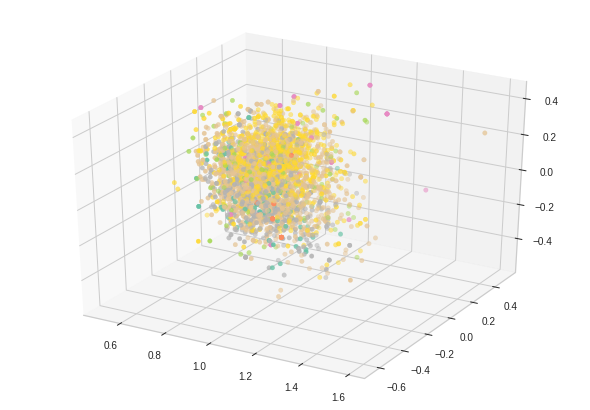

In [0]:
Set = sns.color_palette("Set2", 10)
color_mapping = {key:value for (key,value) in enumerate(Set)}
colors = list(map(lambda x: color_mapping[x], y_train))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca[:, 0], pca[:, 1],pca[:, 2], c=colors);
 

---
##Стэкинг

In [0]:
y = data ['quality'] 
X=data.drop(['quality','quality_new'],axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [154]:
#Тут мы добавили классов которых мало.
y_train.value_counts()

6    1532
5    1048
7     585
8     128
4     116
3      60
9      54
Name: quality, dtype: int64

In [0]:
#Наши методы которые будут учваствовать в объединении
kkn=   KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1)
        
dec=    DecisionTreeClassifier(class_weight='balanced')
        
        
rfores=    RandomForestClassifier (random_state = 0, n_jobs = -1, 
                           n_estimators = 100, max_depth = 3,class_weight='balanced_subsample')
lr = LogisticRegression()
xgbust = XGBClassifier(n_jobs=-1, learning_rate=0.1, 
                      n_estimators=721, max_depth=12,max_delta_step=7,max_features=140,min_child_weight=3)

In [0]:
kkn.fit(X_train, y_train)
dec.fit(X_train, y_train)
rfores.fit(X_train, y_train)
lr.fit(X_train, y_train)
xgbust.fit(X_train, y_train)


In [0]:
#Можно было бы написать красивее
a1=kkn.predict_proba(X_test)
a2=dec.predict_proba(X_test)
a3=rfores.predict_proba(X_test)
a4=lr.predict_proba(X_test)
a5=xgbust.predict_proba(X_test)
X_all_tr = (a1 + a2 + a3 + a4 + a5)/5


In [158]:
#выводим точность наших моделей
for i in [kkn,dec,rfores,lr,xgbust]:
  print(i.score(X_test,y_test))

0.509271523178808
0.6026490066225165
0.2860927152317881
0.5145695364238411
0.6821192052980133


In [0]:
res=np.argmax(X_all_tr,axis=1)

In [0]:
for i in range(len(res)):
  res[i]=res[i]+3


In [161]:
#Собственно говоря точность. 
print('Final prediction score: [%.8f]' % accuracy_score(y_test, res))

Final prediction score: [0.66821192]


In [162]:
test=confusion_matrix(y_test, res)
test

array([[ 20,   0,   0,   0,   0,   0,   0],
       [  0,   6,  22,  18,   1,   0,   0],
       [  1,   4, 279, 111,  14,   0,   0],
       [  0,   3, 117, 488,  53,   5,   0],
       [  0,   2,   6, 116, 167,   4,   0],
       [  0,   2,   1,   7,  14,  23,   0],
       [  0,   0,   0,   0,   0,   0,  26]])

---
XGBClassifier тут в целом показывает лучший результат чем любая модель...

0.6821192052980133

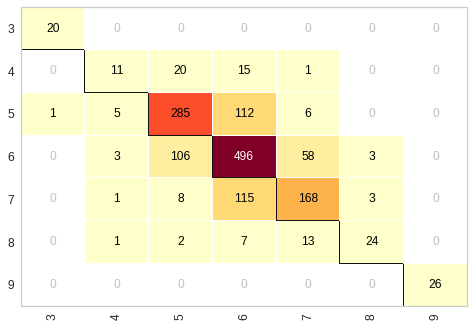

In [163]:
cm = ConfusionMatrix(xgbust, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

In [164]:
from sklearn.ensemble import BaggingClassifier
clf1 = BaggingClassifier(base_estimator=XGBClassifier(n_jobs=-1, learning_rate=0.1, 
                      n_estimators=721, max_depth=12,max_delta_step=7,max_features=140,min_child_weight=3),
                         n_estimators=12).fit(X_train,y_train)
print('XGBClassifier: [%.8f]' % accuracy_score(y_test, clf1.predict(X_test))) 

XGBClassifier: [0.67947020]


In [0]:
pkl_filename = "XGBClassifier-0677.pkl"
with open(pkl_filename, 'wb') as file:
      pickle.dump(xgbust, file)

In [0]:
pkl_filename = "BaggingClassifier-XGBClassifier.pkl"
with open(pkl_filename, 'wb') as file:
      pickle.dump(clf1, file)

---
Далее мы попробуем использовать готовое решение.


In [0]:
#Используемые модели
models = [
   
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
        
    DecisionTreeClassifier(class_weight='balanced'),
        
   XGBClassifier(n_jobs=-1, learning_rate=0.1, 
                      n_estimators=721, max_depth=12,max_delta_step=7,max_features=140,min_child_weight=3),

    SVC(gamma='auto')
    

]

In [0]:
from vecstack import stacking
from sklearn.metrics import accuracy_score

In [0]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=7, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
                           
                           verbose=1)

task:         [classification]
n_classes:    [7]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [KNeighborsClassifier]
    ----
    MEAN:     [0.46693648] + [0.01517098]
    FULL:     [0.46693159]

model  1:     [DecisionTreeClassifier]
    ----
    MEAN:     [0.57365557] + [0.01840937]
    FULL:     [0.57365881]

model  2:     [XGBClassifier]
    ----
    MEAN:     [0.66051706] + [0.01412654]
    FULL:     [0.66051661]

model  3:     [SVC]
    ----
    MEAN:     [0.55350381] + [0.01339348]
    FULL:     [0.55350554]



In [0]:
import numpy as np

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, S_train, y_train, cv=3).mean()
    
    print(current_score, params)
    return -current_score
 
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_features': hp.quniform('max_features', 1,150,5),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'max_delta_step': hp.quniform('max_delta_step', 1, 10, 1),
            'subsample': hp.quniform('subsample', 0, 1, 0.1)
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10,verbose=0)
print('best:', best)

0.6519980185339568
{'eta': 0.4, 'max_delta_step': 6.0, 'max_depth': 1, 'max_features': 125.0, 'min_child_weight': 6.0, 'n_estimators': 442, 'subsample': 0.9}
0.6483076588495414
{'eta': 0.325, 'max_delta_step': 7.0, 'max_depth': 10, 'max_features': 10.0, 'min_child_weight': 3.0, 'n_estimators': 738, 'subsample': 1.0}
0.01646332475503522
{'eta': 0.05, 'max_delta_step': 5.0, 'max_depth': 9, 'max_features': 115.0, 'min_child_weight': 1.0, 'n_estimators': 100, 'subsample': 0.0}
0.650577887322242
{'eta': 0.42500000000000004, 'max_delta_step': 6.0, 'max_depth': 5, 'max_features': 110.0, 'min_child_weight': 5.0, 'n_estimators': 106, 'subsample': 0.8}
0.6514289511520293
{'eta': 0.15000000000000002, 'max_delta_step': 9.0, 'max_depth': 4, 'max_features': 120.0, 'min_child_weight': 5.0, 'n_estimators': 199, 'subsample': 0.2}
0.6494426522647915
{'eta': 0.4, 'max_delta_step': 9.0, 'max_depth': 6, 'max_features': 15.0, 'min_child_weight': 2.0, 'n_estimators': 354, 'subsample': 0.8}
0.6483059673541387

####Выводы. 
Стэкинг при использовании различных способов классификации дает улучшение картины. Судьективно улучшение составило порядка 5%. Так же стоит рассматривать готовые решения для стэкинга. В нашем случае улучшения нет так как есть модель которая явно лучше всех остальных моделей.

----
##Бустинг

In [0]:
y = data ['quality'] 
X=data.drop(['quality','quality_new'],axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [94]:
#собственно говоря сам бустинг. k - число итераций, мы выкидываем те значения которые совпали и вероятность которых больше 0.9. GridSearchCV не самый лучший вариант. 
k=1
pkl_filename = "filename.pkl"
X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_train, y_train, test_size=0.3) #Делим тестовыю выборку на еще 2 выборки. 
count_res=0 #Базовая точность (с которой мы сравниваем перед сохранением модели). 
for_plot=[]#Точнасть которая будет отображаться на графике
max_k=10#Максимальное число итареций
while(True):
  def f(i):
   if np.max(i)>(0.9-k/(2*max_k)): #шаг с которым мы будем ухудшать условие отбора для ускорения спуска (уменьшения выборки)
     return (np.argmax(i)+3)
   else:
    return -1   

  
  clfst = RandomForestClassifier(max_features='sqrt',min_samples_split=2) #базовая модель

  parameters = {'criterion': ['gini', 'entropy'],  #параметры которые мы будем оптимизировать. Можно еще добавить но явно ухудшиться скорость. 
                         'max_depth': [3, 4, 6, 10],
                         'n_estimators': [200, 500]},
  
  clfcvs = GridSearchCV(clfst, parameters).fit(X_train_valid, y_train_valid)
  
  if clfcvs.score(X_test_valid,y_test_valid)>count_res: 
    count_res=clfcvs.score(X_test_valid,y_test_valid)
    #сохраняем лучшую модель
    with open(pkl_filename, 'wb') as file:
      pickle.dump(clfcvs, file)
      

  print('Базовая точность на итерации ',k,'   ',clfcvs.score(X_test_valid,y_test_valid))
  for_plot.append(clfcvs.score(X_test_valid,y_test_valid))
  
  new_df=X_test_valid.copy()

  pred=clfcvs.predict_proba(X_test_valid) 
#далее мы фильтруем наши данные и удаляем текоторые не соответствуют условию фильтра (f(i))
  new_df['predict']=y_test_valid  
  new_df['proba']=[f(i) for i in pred]

  X_test_valid=new_df[new_df['predict']!=new_df['proba']]
  
  y_test_valid = X_test_valid['predict'] 
  X_test_valid=X_test_valid.drop(['proba','predict'],axis=1)

#условие выхода из массива    
  print('Номер итерации ',k)
  if k>max_k:
    break
  k=k+1
#обьединям и перемешиваем
  X_train=pd.concat([X_train_valid, X_test_valid])
  y_train=pd.concat([y_train_valid, y_test_valid])
  print('Размер выборки, ',len(y_train))  
  X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_train, y_train, test_size=0.3)
 

Базовая точность на итерации  1     0.6499526963103122
Номер итерации  1
Размер выборки,  3500
Базовая точность на итерации  2     0.6238095238095238
Номер итерации  2
Размер выборки,  3484
Базовая точность на итерации  3     0.6195028680688337
Номер итерации  3
Размер выборки,  3452
Базовая точность на итерации  4     0.6177606177606177
Номер итерации  4
Размер выборки,  3387
Базовая точность на итерации  5     0.615535889872173
Номер итерации  5
Размер выборки,  3259
Базовая точность на итерации  6     0.6032719836400818
Номер итерации  6
Размер выборки,  3115
Базовая точность на итерации  7     0.5754010695187166
Номер итерации  7
Размер выборки,  2933
Базовая точность на итерации  8     0.5704545454545454
Номер итерации  8
Размер выборки,  2733
Базовая точность на итерации  9     0.4902439024390244
Номер итерации  9
Размер выборки,  2441


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Базовая точность на итерации  10     0.41336971350613916
Номер итерации  10
Размер выборки,  2185
Базовая точность на итерации  11     0.3902439024390244
Номер итерации  11


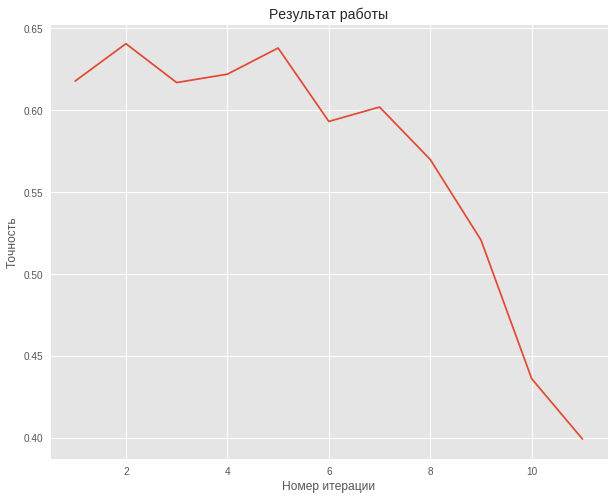

In [0]:

plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.title('Результат работы', fontsize=14)
plt.ylabel('Точность')
plt.xlabel('Номер итерации')
plt.plot(range(1,len(for_plot)+1), for_plot);

In [0]:
pkl_filename = "filename.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

score = pickle_model.score(X_test, y_test)

In [0]:
print('Точность ',score)

Точность  0.6410596026490066


0.6410596026490066

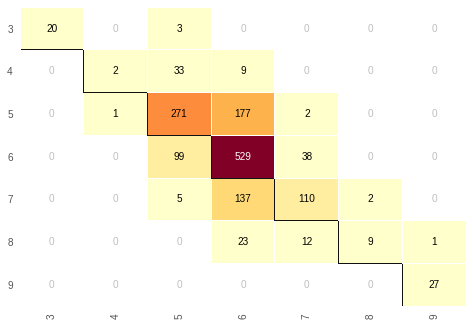

In [0]:
cm = ConfusionMatrix(pickle_model, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

Результат оказался в среднем хуже чем другие методы. Однако это скорее результат реализации. Подбор параметров на лету через GridSearchCV сильно затратен по ресурсам. 

---
##Бэгинг

In [0]:
data=shuffle(data)

In [166]:
data.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'quality_new', 'chloridesnew',
       'densitynew', 'alcoholnew'],
      dtype='object')

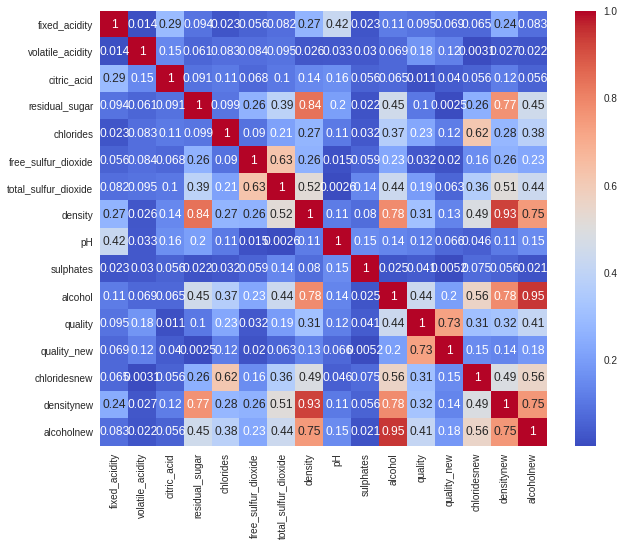

In [176]:
corr_matrix = data.corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [0]:
y = data ['quality'] 
X=data.drop(['quality','quality_new','chloridesnew','densitynew'],axis=1)
#X_train, X_test, y_train, y_test = train_test_split(newX, newy, test_size=0.3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [199]:
data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_new,chloridesnew,densitynew,alcoholnew
4516,0.230769,0.235294,0.192771,0.024540,0.080119,0.045296,0.141531,0.053788,0.400000,0.302326,0.758065,6,1,4,4,1
3819,0.125000,0.264706,0.156627,0.095092,0.074184,0.118467,0.257541,0.091961,0.600000,0.209302,0.564516,6,1,4,4,2
1595,0.250000,0.186275,0.295181,0.102761,0.109792,0.177700,0.457077,0.163678,0.472727,0.244186,0.193548,6,1,2,2,4
676,0.201923,0.205882,0.150602,0.174847,0.142433,0.160279,0.498840,0.211876,0.463636,0.220930,0.161290,6,1,1,1,4
934,0.230769,0.196078,0.259036,0.190184,0.089021,0.216028,0.519722,0.199345,0.327273,0.186047,0.145161,5,1,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,0.317308,0.147059,0.234940,0.200920,0.145401,0.083624,0.378190,0.201272,0.163636,0.279070,0.161290,6,1,1,1,4
4562,0.173077,0.098039,0.180723,0.147239,0.056380,0.090592,0.283063,0.159823,0.700000,0.232558,0.451613,7,1,4,2,2
4214,0.307692,0.352941,0.144578,0.176380,0.139466,0.229965,0.466357,0.194139,0.300000,0.325581,0.241935,5,1,1,1,4
1067,0.355769,0.107843,0.204819,0.030675,0.083086,0.108014,0.269142,0.100058,0.345455,0.313953,0.500000,7,1,3,3,2


In [0]:

#строим выборку на 0.95 части данных. Делаем предикт для понимания что происходит. 
def bagging(X_train,y_train,X_test,y_test,iteration):
  count_res=0
  pkl_filename = "bestBeg.pkl"
#создаем нулевую матрицу с которой будем сумироваться  
  predict=np.zeros((len(X_test),7))
 # xgbust = XGBClassifier(n_jobs=-1, learning_rate=0.2, 
  #                    n_estimators=721, max_depth=12,max_delta_step=7,max_features=140,min_child_weight=3)
  xgbust = RandomForestClassifier(class_weight='balanced',max_depth=19,max_features='log2',n_estimators=200) #
  for i in range(0,iteration):
    X_train_1, _, y_train_1, _ = train_test_split(X_train, y_train, test_size=0.05)#выборка элементов
    xg=xgbust.fit(X_train_1, y_train_1)
    gg=xg.predict_proba(X_test)


    if xg.score(X_test, y_test)>count_res: 
      count_res=xg.score(X_test, y_test)
    #сохраняем лучшую модель
      with open(pkl_filename, 'wb') as file:
        pickle.dump(xg, file)


    test=np.array(gg,float)
    predict+=test
    print('Точность на итерации ',i,' - ',xg.score(X_test, y_test))
   
  return predict

In [206]:
predic=bagging(X_train,y_train,X_test,y_test,50)


Точность на итерации  0  -  0.6940397350993377
Точность на итерации  1  -  0.695364238410596
Точность на итерации  2  -  0.7033112582781457
Точность на итерации  3  -  0.6933774834437086
Точность на итерации  4  -  0.6894039735099338
Точность на итерации  5  -  0.6854304635761589
Точность на итерации  6  -  0.6960264900662252
Точность на итерации  7  -  0.6960264900662252
Точность на итерации  8  -  0.6913907284768211
Точность на итерации  9  -  0.6913907284768211
Точность на итерации  10  -  0.6993377483443709
Точность на итерации  11  -  0.6887417218543046
Точность на итерации  12  -  0.695364238410596
Точность на итерации  13  -  0.6927152317880795
Точность на итерации  14  -  0.6907284768211921
Точность на итерации  15  -  0.6887417218543046
Точность на итерации  16  -  0.6933774834437086
Точность на итерации  17  -  0.6947019867549669
Точность на итерации  18  -  0.6887417218543046
Точность на итерации  19  -  0.6841059602649007
Точность на итерации  20  -  0.6993377483443709
Точн

In [0]:
res=np.argmax(predic,axis=1)

In [0]:
for i in range(len(res)):
  res[i]=res[i]+3


In [209]:
print('Final prediction score: [%.8f]' % accuracy_score(y_test, res))
#точность в итоге выше чем у любого из предложенных методов

Final prediction score: [0.70132450]


In [0]:
#вариант с увеличением объема данных
from imblearn.over_sampling import ADASYN,SMOTE
ada = SMOTE(random_state=42)
y_y = y_train.copy()
X_X=X_train.copy()
newX,new_y=SMOTE(random_state=42).fit_resample(X_X,y_y)
newData=newX.copy()

In [197]:
predic=bagging(newX,new_y,X_test,y_test,15)

Точность на итерации  0  -  0.6516556291390728
Точность на итерации  1  -  0.6476821192052981
Точность на итерации  2  -  0.6596026490066225
Точность на итерации  3  -  0.6483443708609271
Точность на итерации  4  -  0.6516556291390728
Точность на итерации  5  -  0.6437086092715232
Точность на итерации  6  -  0.6476821192052981
Точность на итерации  7  -  0.6529801324503312
Точность на итерации  8  -  0.6562913907284769
Точность на итерации  9  -  0.6529801324503312
Точность на итерации  10  -  0.6483443708609271
Точность на итерации  11  -  0.652317880794702
Точность на итерации  12  -  0.6622516556291391
Точность на итерации  13  -  0.6503311258278146
Точность на итерации  14  -  0.6562913907284769


In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
clf = BaggingClassifier(base_estimator=XGBClassifier(n_jobs=-1, learning_rate=0.1, 
                      n_estimators=721, max_depth=12,max_delta_step=7,max_features=140,min_child_weight=3,subsample=1),
                         n_estimators=12).fit(X_train,y_train)

In [0]:
print('Final prediction score: [%.8f]' % accuracy_score(y_test, clf.predict(X_test)))


In [0]:
cm = ConfusionMatrix(clf, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

---
Проверяем модель

In [0]:
pkl_filename = "bestBeg.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

score = pickle_model.score(X_test, y_test)

In [211]:
print('Точность ',score)

Точность  0.7033112582781457


0.7033112582781457

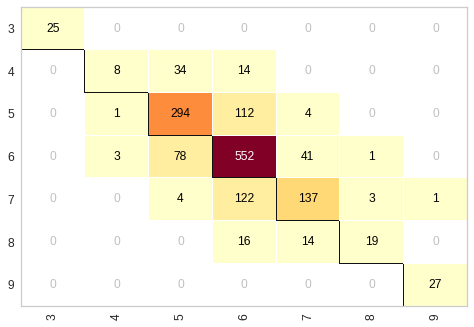

In [212]:
cm = ConfusionMatrix(pickle_model, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)




**Вывод:**
Бэкинг показал самый лучший результат из всех предложенных методов. Так же стоит обратить внимание на то, что размер выборки должен быть почти равен начальонй (95% от тестовой у нас). То есть я выкидываю случайные 5% от выборки. Это говорит о малом числе данных. 

#Выводы по всей работе.
1) Если имееться метод который дает хороший результат то если мы хотим его улучшить на 3-5% стоит использовать Bagging. Данный метод даст в целом неплохое улучшение. В данной работе был получен максимальный результат на уровне **0.7**.  <br>
2) Если у нас есть много разных моделей низкой точности то стоит обратить внимание на Стэкинг. Однако если есть модель которая явно лучше всех остальных - итоговый результат будет ниже чем в этой модели (тогда стоит использовать Bagging)<br>
3) Бустинг показал не самый лучший результат по итогу. Возможно алгоритм требует доработки. 

---
Ниже мы пробуем сделать простую нейронную сеть

---

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
new_data=data.copy()

new_data['quality']=[i-3 for i in new_data['quality']]
y = new_data ['quality']

X=new_data.drop('quality',axis=1)

In [0]:
new_data['quality'].max()

6

In [0]:
data_poly_new=poly.fit_transform(X)

In [0]:
X.shape

(5033, 14)

In [0]:
X.drop('quality_new',axis=1,inplace=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

---

In [0]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as ll
from tensorflow.keras.utils import to_categorical

In [0]:
model = Sequential(name="mlp")

model.add(ll.Dense(128, 
                activation='relu',  
                input_dim=14,
                kernel_initializer='uniform'))
model.add(ll.BatchNormalization())

model.add(ll.Dropout(0.5))

model.add(ll.Dense(64,
                kernel_initializer='uniform',
                activation='relu'))
model.add(ll.BatchNormalization())
model.add(ll.Dropout(0.5))

model.add(ll.Dense(32,
                kernel_initializer='uniform',
                activation='relu'))
model.add(ll.BatchNormalization())
model.add(ll.Dropout(0.5))

model.add(ll.Dense(16,
                kernel_initializer='uniform',
                activation='relu'))
model.add(ll.BatchNormalization())

model.add(ll.Dropout(0.3))
model.add(ll.Dense(7, activation = "softmax"))

from tensorflow.keras.optimizers import Adam

optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile('SGD', "sparse_categorical_crossentropy", metrics=["accuracy"])



In [0]:
batch_size = 4

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks_list = [
       ModelCheckpoint(
        filepath='my_model-1.h5',
        monitor='val_loss',
        save_best_only=True,)
]


history=model.fit(X_train, y_train,
          validation_data=(X_test,y_test), epochs=15,callbacks=callbacks_list,batch_size = 10,verbose=1);

Train on 3523 samples, validate on 1510 samples
Epoch 1/15
3523/3523 [==============================] - 2s 617us/sample - loss: 1.8442 - acc: 0.3074 - val_loss: 1.4225 - val_acc: 0.4497
Epoch 2/15
3523/3523 [==============================] - 1s 290us/sample - loss: 1.4959 - acc: 0.4133 - val_loss: 1.3639 - val_acc: 0.4444
Epoch 3/15
3523/3523 [==============================] - 1s 294us/sample - loss: 1.4424 - acc: 0.4156 - val_loss: 1.3527 - val_acc: 0.4424
Epoch 4/15
3523/3523 [==============================] - 1s 290us/sample - loss: 1.4091 - acc: 0.4232 - val_loss: 1.3489 - val_acc: 0.4437
Epoch 5/15
3523/3523 [==============================] - 1s 281us/sample - loss: 1.3931 - acc: 0.4249 - val_loss: 1.3390 - val_acc: 0.4510
Epoch 6/15
3523/3523 [==============================] - 1s 276us/sample - loss: 1.3872 - acc: 0.4303 - val_loss: 1.3376 - val_acc: 0.4417
Epoch 7/15
3523/3523 [==============================] - 1s 291us/sample - loss: 1.3878 - acc: 0.4303 - val_loss: 1.3620 - va

In [0]:
scores = model.evaluate(X_train, y_train, batch_size=30)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3523/3523 [==============================] - 0s 42us/sample - loss: 1.3479 - acc: 0.4340
acc: 43.40%


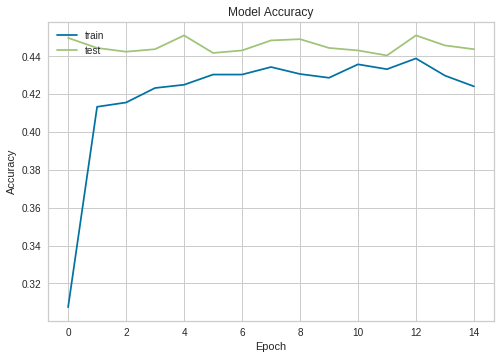

In [0]:
# summarizing historical accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Точность так себе...

---

Тут код при помощи которого мы подбирали гиперпараметры.

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X_train,y_train, cv=3).mean()
    print(current_score, params)
    return -current_score
    if acc < min_acc:
         clf.sa
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_features': hp.quniform('max_features', 1,150,5),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'max_delta_step': hp.quniform('max_delta_step', 1, 10, 1),
            'subsample': hp.quniform('subsample', 0, 1, 0.1)
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:', best)

---

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = DecisionTreeClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X_train,y_train, cv=3).mean()
    print(current_score, params)
    return -current_score

In [0]:
simple_space_xgb = {
     'max_depth':  hp.choice('max_depth', np.arange(1, 30, dtype=int)),
        
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=15)
print('best:',best)

---

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = KNeighborsClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X_train,y_train, cv=3).mean()
    print(current_score, params)
    return -current_score

In [0]:
simple_space_xgb = {
          
            'n_neighbors': hp.choice('n_neighbors', np.arange(1, 14, dtype=int)),
            'p': hp.quniform('p', 1,2,1),
            'algorithm':  hp.choice('algorithm', {'auto', 'ball_tree', 'kd_tree', 'brute'}),
            'leaf_size': hp.quniform('leaf_size', 20, 100, 10)
            
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:', best)

0.4598330252395278
{'algorithm': 'ball_tree', 'leaf_size': 60.0, 'n_neighbors': 7, 'p': 1.0}
0.4430855292568294
{'algorithm': 'ball_tree', 'leaf_size': 80.0, 'n_neighbors': 7, 'p': 2.0}
0.45926468278420146
{'algorithm': 'ball_tree', 'leaf_size': 20.0, 'n_neighbors': 6, 'p': 1.0}
0.44394239249942613
{'algorithm': 'auto', 'leaf_size': 100.0, 'n_neighbors': 9, 'p': 2.0}
0.4479116072830959
{'algorithm': 'kd_tree', 'leaf_size': 70.0, 'n_neighbors': 10, 'p': 2.0}
0.474594463977189
{'algorithm': 'brute', 'leaf_size': 90.0, 'n_neighbors': 2, 'p': 2.0}
0.44734157333236674
{'algorithm': 'ball_tree', 'leaf_size': 40.0, 'n_neighbors': 3, 'p': 2.0}
0.44734157333236674
{'algorithm': 'auto', 'leaf_size': 40.0, 'n_neighbors': 3, 'p': 2.0}
0.4479116072830959
{'algorithm': 'brute', 'leaf_size': 80.0, 'n_neighbors': 10, 'p': 2.0}
0.470047241050177
{'algorithm': 'brute', 'leaf_size': 90.0, 'n_neighbors': 3, 'p': 1.0}
100%|██████████| 10/10 [00:02<00:00,  3.68it/s, best loss: -0.474594463977189]
best: {'al

---

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = RandomForestClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X_train,y_train, cv=3).mean()
    print(current_score, params)
    return -current_score

In [0]:
simple_space_xgb = {
           
            'max_depth': hp.choice('max_depth', np.arange(1, 20, dtype=int)),
            'class_weight':  hp.choice('class_weight', {'balanced', 'balanced_subsample'}),
            'max_features':  hp.choice('max_features', {'auto', 'sqrt', 'log2'}),
            'n_estimators': hp.choice('n_estimators', np.arange(100, 600,50, dtype=int)),
            
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:', best)

0.2784600142568898
{'class_weight': 'balanced_subsample', 'max_depth': 1, 'max_features': 'auto', 'n_estimators': 150}
0.6483132166201505
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 300}
0.6429187961385576
{'class_weight': 'balanced', 'max_depth': 17, 'max_features': 'auto', 'n_estimators': 550}
0.6449036451725929
{'class_weight': 'balanced', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 100}
0.6128280594923097
{'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 100}
0.5895583988787801
{'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}
0.47914096197759976
{'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 400}
0.4799917841651866
{'class_weight': 'balanced_subsample', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 450}
0.41981973491850616
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_fe

---
Мы пропускаем все подобранные модели через BaggingClassifier с целью максимализации точности. 

In [0]:
from sklearn.ensemble import BaggingClassifier
clf1 = BaggingClassifier(base_estimator=XGBClassifier(n_jobs=-1, learning_rate=0.1, 
                      n_estimators=721, max_depth=12,max_delta_step=7,max_features=140,min_child_weight=3,subsample=1),
                         n_estimators=12).fit(X_train,y_train)
print('XGBClassifier: [%.8f]' % accuracy_score(y_test, clf1.predict(X_test)))                       

XGBClassifier: [0.66887417]


0.6688741721854304

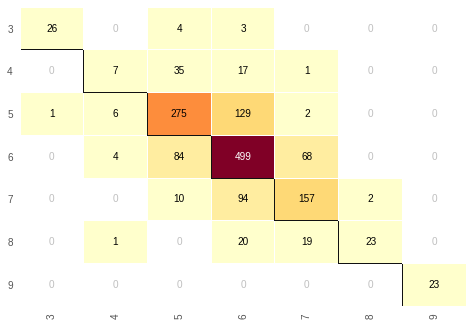

In [0]:
cm = ConfusionMatrix(clf1, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf2 = BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=50, 
                      n_neighbors=9, p=1),
                         n_estimators=12).fit(X_train,y_train)
print('KNeighborsClassifier: [%.8f]' % accuracy_score(y_test, clf2.predict(X_test)))

KNeighborsClassifier: [0.47549669]


0.47549668874172185

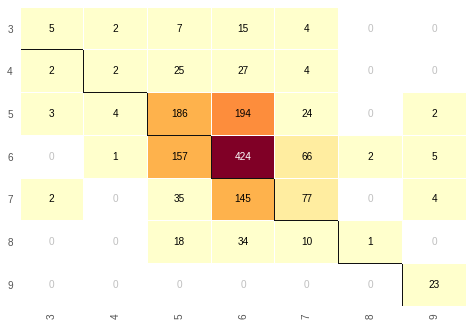

In [0]:
cm = ConfusionMatrix(clf2, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf3 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                         n_estimators=12).fit(X_train,y_train)
print('DecisionTreeClassifier: [%.8f]' % accuracy_score(y_test, clf3.predict(X_test)))

DecisionTreeClassifier: [0.65430464]


0.6543046357615894

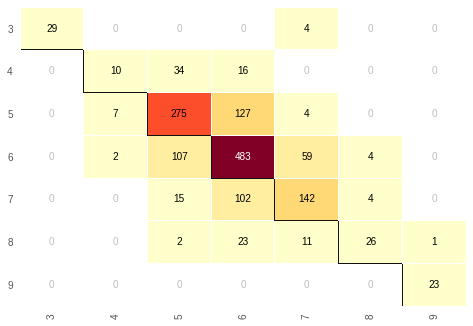

In [0]:
cm = ConfusionMatrix(clf3, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

In [227]:
from sklearn.ensemble import RandomForestClassifier
clf4 = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',max_depth=19,max_features='log2',n_estimators=200),
                         n_estimators=12).fit(X_train,y_train)
print('DecisionTreeClassifier: [%.8f]' % accuracy_score(y_test, clf4.predict(X_test)))

DecisionTreeClassifier: [0.69602649]


0.6960264900662252

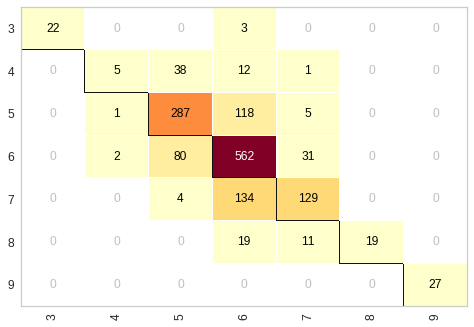

In [228]:
cm = ConfusionMatrix(clf4, classes=[3,4,5,6,7,8,9])
cm.score(X_test, y_test)

---

In [225]:
!pip install freeze

  Created wheel for freeze: filename=freeze-1.0.10-cp36-cp36m-linux_x86_64.whl size=613624 sha256=e112b6c553681b7b8eba6b7b120fce4363699fffdf4cf6c13618166b9c7bbc34
  Stored in directory: /root/.cache/pip/wheels/5a/01/6b/b8d944e726b251e0f68a8786a3d26193c16f2883ae6f19c71a
Successfully built freeze


In [0]:
!pip freeze > requirements.txt